# PyTorch实战: CIFAR10图像分类

## 1 任务目标

### 1.1 用多层感知机(MLP)和卷积网络(ConvNet)完成CIFAR10分类

   使用PyTorch分别实现多层感知机(MLP)和卷积网络(ConvNet)，并完成CIFAR10数据集（http://www.cs.toronto.edu/~kriz/cifar.html） 分类。本案例不提供初始代码，请自行配置网络和选取超参数，包括层数、卷积核数目、激活函数类型、损失函数类型、优化器等方面。

   提交所有代码和一份案例报告，要求如下：

- 详细介绍所使用的模型及其结果，至少包括超参数选取，损失函数、准确率及其曲线；

- 比较不同模型配置下的结果，<font color='red'>至少从三个方面</font>作比较和分析，例如层数、卷积核数目、激活函数类型、损失函数类型、优化器等。

### 1.2 学习PyTorch ImageNet分类示例

   请自行学习PyTorch官方提供的ImageNet分类示例代码，以便更好地完成后续案例(https://github.com/pytorch/examples/tree/master/imagenet)，这部分无需提交代码和报告。

### 1.3 注意事项

- 提交所有代码和一份案例报告；

- 禁止任何形式的抄袭。

## 2 代码设计
导入相应库

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('darkgrid')

### 2.1 初始化及数据预处理
1. 设置设备

In [2]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('training on', device)

training on cuda


2. 数据预处理以及数据增强
    
    该部分负责在创建数据集时，对数据进行数据增强和预处理，具体操作如下：
    - 训练集数据处理：
        
        - 随机水平翻转`RandomHorizontalFlip()`：以0.5的概率随机水平翻转图像。
        
        - 随机旋转`RandomRotation(5)`：在-5度到5度之间随机旋转图像。
        
        - 颜色抖动`ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)`：对图像进行颜色抖动，包括亮度、对比度和饱和度的随机变化。
        
        - 随机裁剪`RandomResizedCrop(32, scale=(0.9, 1.0))`：对图像进行随机裁剪，然后重新调整大小到指定的尺寸（这里是32x32像素）。
        
        - 张量转换`ToTensor()`：将图像转换为PyTorch张量。

        - 图像标准化`Normalize`：对图像进行标准化，将像素值缩放到[-1, 1]的范围。

    - 测试集数据处理：

        - 张量转换`ToTensor()`：将图像转换为PyTorch张量。
        
        - 图像标准化`Normalize`：对图像进行标准化，将像素值缩放到[-1, 1]的范围。

        
    

In [3]:
# 数据增强和预处理
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(32, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

3. 数据集创建

    CIFAR-10 数据集是一个用于图像分类的常用数据集，该数据集包含了10个类别的彩色图像，每个类别有6,000张图像，共计60,000张图像。每张图像的尺寸是32x32像素。

    该部分用于下载CIFAR-10数据集，并按指定预处理操作，创建训练集和测试集。
    - `torchvision.datasets.CIFAR10`: 这是PyTorch中专门用于加载CIFAR-10数据集的类。
    - `root='./data'`: 这指定了数据集将被下载到的本地目录。
    - `train=True`和`train=False`: 当train=True时，表示创建训练集；当train=False时，表示创建测试集。
    - `download=True`: 如果本地没有找到CIFAR-10数据集，设置为True时，PyTorch将自动下载并解压缩数据集。
    - `transform=transform`: 这里的transform参数指定了数据集中图像的预处理操作。

In [4]:
# 加载CIFAR-10数据集并进行划分
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


4. 创建数据加载器

    创建用于训练和测试的数据加载器（DataLoader）。`train_loader`用于训练，`test_loader`用于测试。
    
    这些数据加载器在训练和测试过程中会循环提供每个批次的图像和标签，方便使用PyTorch的模型进行训练和评估。

    - `torch.utils.data.DataLoader`: 这是PyTorch中的一个类，用于从数据集中加载批量的数据。
    - `batch_size=64`: 这指定了每个批次加载的图像数量。
    - `shuffle=True`和`shuffle=False`: 这表示是否在每个epoch开始时随机打乱数据。在训练集中，通常希望打乱数据以防止模型学到数据的顺序性，而在测试集中则可以保持数据的原始顺序。
    - `num_workers=2`: 这指定了用于加载数据的子进程数量。

In [5]:
# 创建数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

5. 显示数据集图片

    将一个批次（64）的数据集图像及标签通过 `Matplotlib` 显示出来。

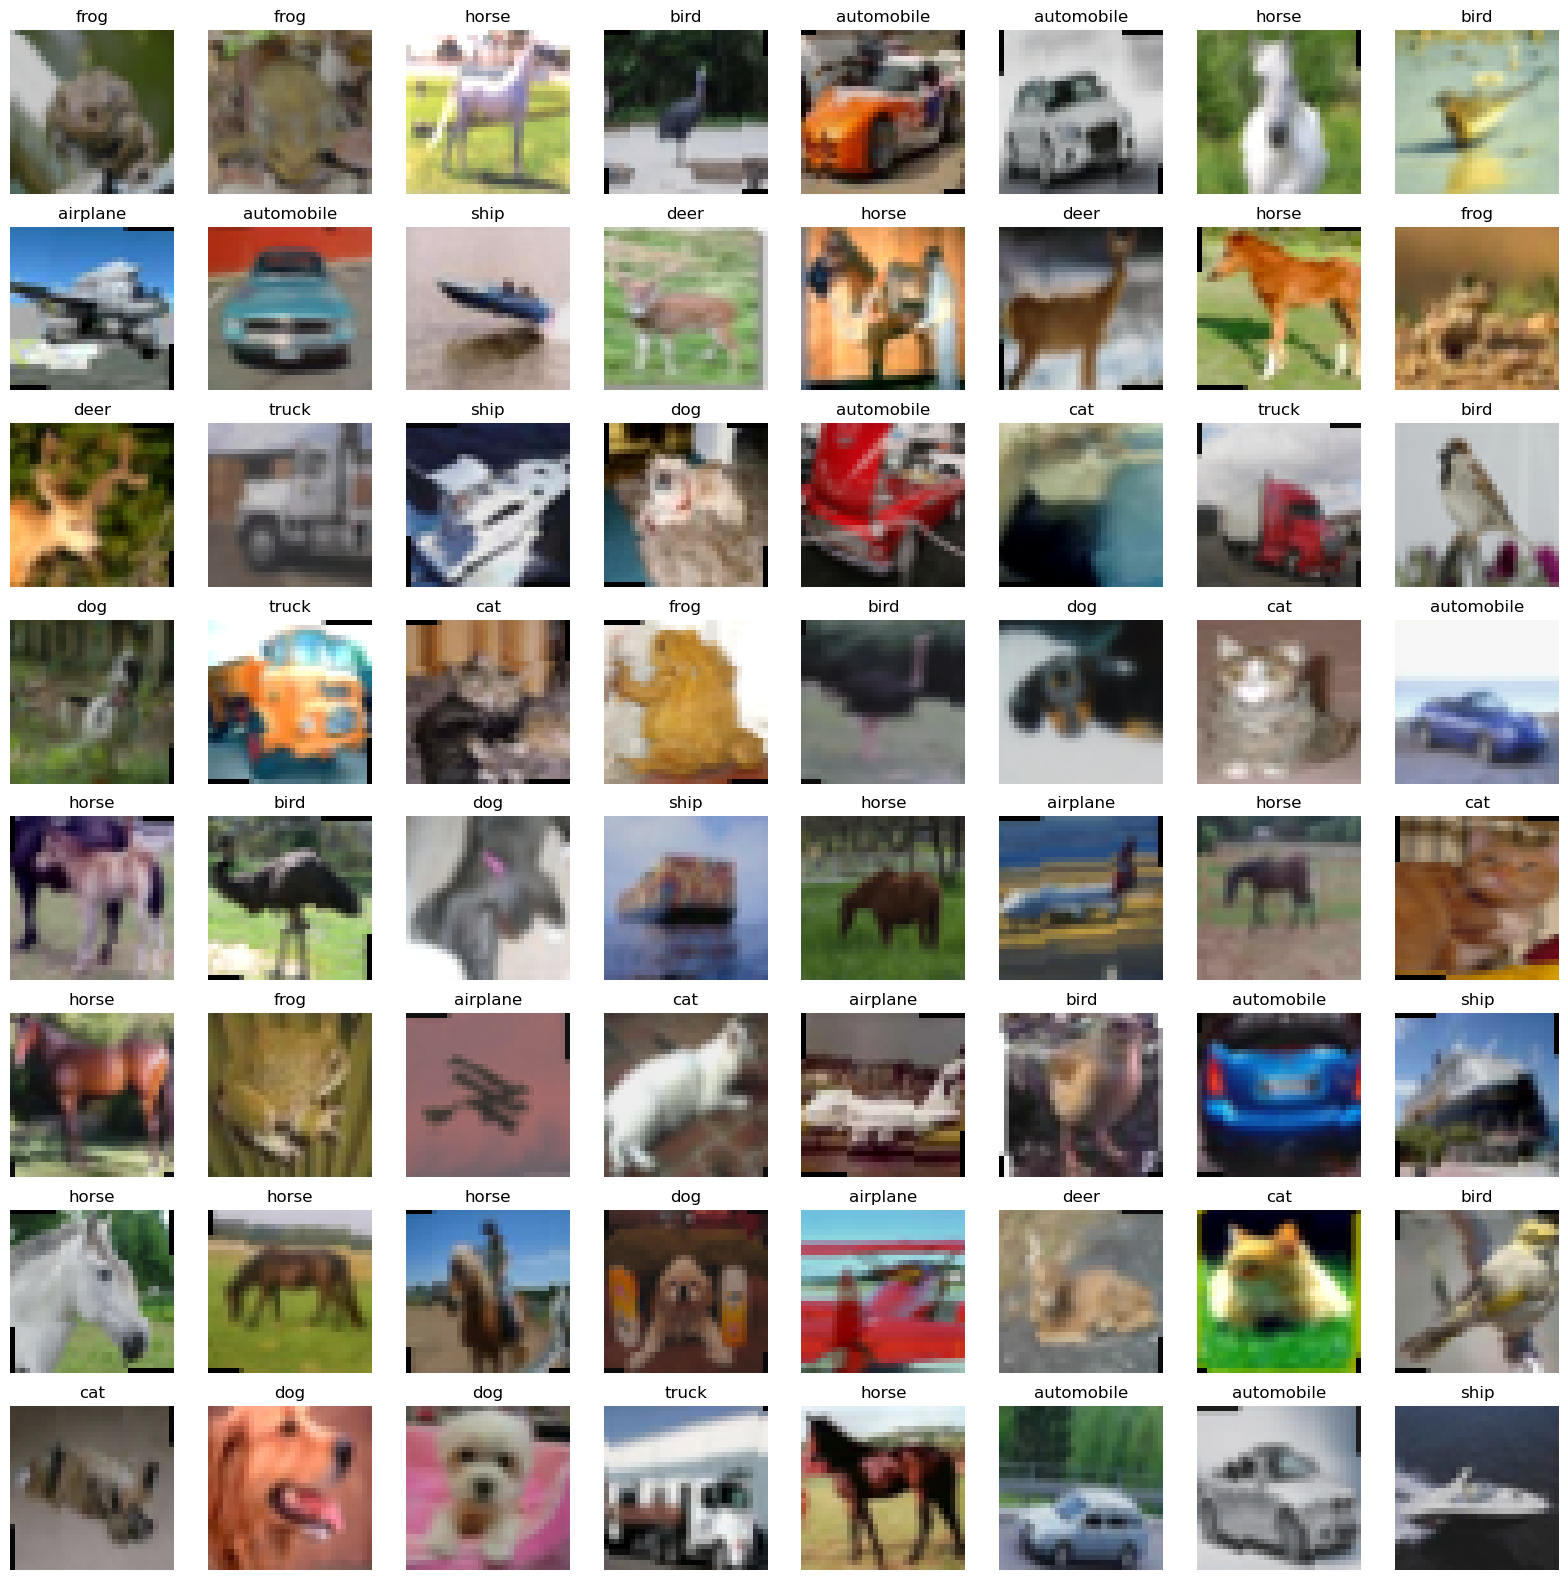

In [6]:
# 获取一个批次的图像和标签
for images, labels in train_loader:
    break  # 获取第一个批次后就跳出循环

# 将张量转换为NumPy数组
images = images.numpy()

# 反归一化
images = (images * 0.5) + 0.5

# 定义标签对应的类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 显示图像和标签
plt.figure(figsize=(20, 20))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.title(class_names[labels[i]])
    plt.axis('off')

plt.show()

可以看到，显示出的图像经过了数据增强，有的图像经过了旋转、翻转以及缩放。

### 2.2 模型建立
1. 建立MLP模型

    MLP模型由三个全连接层组成，通过ReLU激活函数进行非线性变换，最终输出一个10维的张量，表示对每个类别的预测得分。

In [6]:
# 定义MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    
MLP()

MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

2. 建立自定义MLP模型
    
    在这个 DefMLP 模型中，可以调整层数`num_layers`,激活函数 `activation_func`。

In [7]:
class DefMLP(nn.Module):
    def __init__(self, num_layers, activation_func):
        super(DefMLP, self).__init__()

        layers = []
        input_size = 32 * 32 * 3
        for _ in range(num_layers):
            layers.append(nn.Linear(input_size, 512))
            input_size = 512  # 更新输入大小
            if activation_func == 'relu':
                layers.append(nn.ReLU())
            elif activation_func == 'sigmoid':
                layers.append(nn.Sigmoid())
            else:
                raise ValueError("Invalid activation function")

        self.layers = nn.Sequential(*layers)
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        x = self.fc(x)
        return x
    

3. 建立简单卷积神经网络模型

    这个ConvNet模型包含了两个卷积层和两个全连接层，通过ReLU激活函数进行非线性变换，并通过最大池化进行下采样。

In [8]:
# 定义ConvNet模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

ConvNet()

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [9]:
class ConvNet_3layers(nn.Module):
    def __init__(self):
        super(ConvNet_3layers, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

ConvNet_3layers()

ConvNet_3layers(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [10]:
class ConvNet_4(nn.Module):
    def __init__(self):
        super(ConvNet_4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

ConvNet_4()

ConvNet_4(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

4. 建立包含BN层的卷积神经网络模型


In [11]:
# 定义卷积神经网络模型（包含BN层）
class ConvNetBN(nn.Module):
    def __init__(self):
        super(ConvNetBN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.bn3(self.fc1(x)))
        x = self.fc2(x)
        return x
    
ConvNetBN()

ConvNetBN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### 2.3 模型训练

#### 2.3.1 训练函数创建

1. 建立训练函数

    本次实验采用了两种训练函数，一种是普通的训练函数，另一种是采用早停法的训练函数。

    - `train(model, optimizer, criterion, num_epochs)`：训练&测试函数，根据输入的模型`model`、优化器`optimizer`以及损失函数`criterion`进行指定轮次`num_epochs`的训练。训练后，在测试集上进行测试，并将训练集、测试集上该轮次的准确率和损失记录，并返回。

    - `train_with_early_stopping(model, optimizer, criterion, num_epochs, patience=3)`：采用早停法的训练函数，输出参数里比以上函数多了个`patience`，代表若训练时若测试集上的loss连续3次都未降低则停止训练。

In [12]:
# 训练函数
def train(model, optimizer, criterion, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # 在测试集上评估模型
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_accuracy = correct_test / total_test
        test_losses.append(running_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracy:.4f}')

    return train_losses, train_accuracies, test_losses, test_accuracies

基于早停法的训练函数：

In [13]:
def train_with_early_stopping(model, optimizer, criterion, num_epochs, patience=3):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    model.to(device)

    best_validation_loss = float('inf')  # 初始最佳验证集损失为正无穷
    early_stopping_counter = 0  # 连续未减小的epoch计数器

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # 在验证集上评估模型
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

            test_accuracy = correct_test / total_test
            test_losses.append(running_loss / len(test_loader))
            test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch + 1}/{num_epochs}, '
                  f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, '
                  f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracy:.4f}')

            # 判断是否进行早停
            if test_losses[-1] < best_validation_loss:
                best_validation_loss = test_losses[-1]
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f'Validation loss has not decreased for {patience} consecutive epochs. Early stopping...')
                break

    return train_losses, train_accuracies, test_losses, test_accuracies

2. 绘制曲线函数

In [14]:
def drawlines(train_losses, train_accuracies, test_losses, test_accuracies):
    # 绘制损失和准确率曲线
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title(f'Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

3. 各个类别测试

In [15]:
def ClassTest(model):
    model.to(device)
    model.eval()

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        c = (preds == labels)
        c = c.squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    class_accuarcy=[]     
    for i in range(10):
        print(f"Accuracy of {class_names[i]:>10} : {np.round(100 * class_correct[i].detach().cpu().numpy() / class_total[i], 2)}%")
        class_accuarcy.append(np.round(100 * class_correct[i].detach().cpu().numpy() / class_total[i], 2))
    
    return class_accuarcy

#### 2.3.2 模型训练


In [16]:
train_losses_all = []
train_accuracies_all = []
test_losses_all = []
test_accuracies_all = []
class_accuarcy_all = []

1. MLP模型训练

    对比不同MLP层数、激活函数、优化器对MLP网络训练的影响

Epoch 1/20, Train Loss: 2.2175, Train Acc: 0.2465, Test Loss: 2.1313, Test Acc: 0.3284
Epoch 2/20, Train Loss: 2.1088, Train Acc: 0.3523, Test Loss: 2.0730, Test Acc: 0.3862
Epoch 3/20, Train Loss: 2.0723, Train Acc: 0.3853, Test Loss: 2.0438, Test Acc: 0.4153
Epoch 4/20, Train Loss: 2.0458, Train Acc: 0.4153, Test Loss: 2.0246, Test Acc: 0.4323
Epoch 5/20, Train Loss: 2.0251, Train Acc: 0.4348, Test Loss: 2.0073, Test Acc: 0.4530
Epoch 6/20, Train Loss: 2.0130, Train Acc: 0.4461, Test Loss: 1.9928, Test Acc: 0.4646
Epoch 7/20, Train Loss: 1.9999, Train Acc: 0.4584, Test Loss: 1.9833, Test Acc: 0.4755
Epoch 8/20, Train Loss: 1.9896, Train Acc: 0.4693, Test Loss: 1.9816, Test Acc: 0.4775
Epoch 9/20, Train Loss: 1.9836, Train Acc: 0.4762, Test Loss: 1.9762, Test Acc: 0.4792
Epoch 10/20, Train Loss: 1.9758, Train Acc: 0.4827, Test Loss: 1.9679, Test Acc: 0.4907
Epoch 11/20, Train Loss: 1.9666, Train Acc: 0.4914, Test Loss: 1.9723, Test Acc: 0.4842
Epoch 12/20, Train Loss: 1.9626, Train Ac

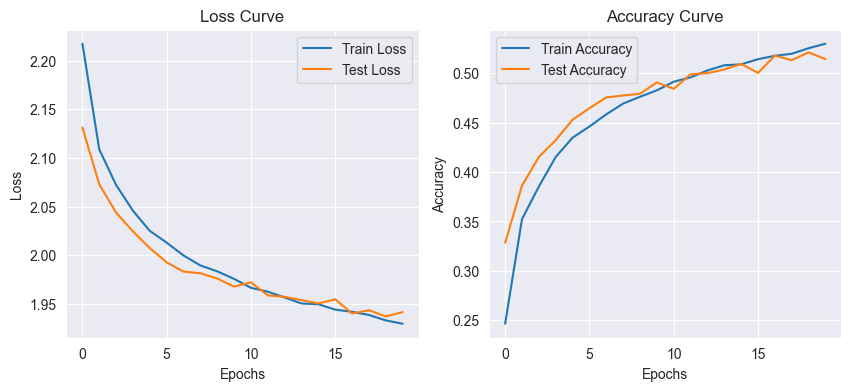

In [17]:
model = MLP().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20
train_losses_mlp, train_accuracies_mlp, test_losses_mlp, test_accuracies_mlp = train(model, optimizer, criterion, num_epochs)

drawlines(train_losses_mlp, train_accuracies_mlp, test_losses_mlp, test_accuracies_mlp)

In [18]:
train_losses_all.append(train_losses_mlp)
train_accuracies_all.append(train_accuracies_mlp)
test_losses_all.append(test_losses_mlp)
test_accuracies_all.append(test_accuracies_mlp)

class_accuarcy_all.append(ClassTest(model))

Accuracy of   airplane : 48.21%
Accuracy of automobile : 68.0%
Accuracy of       bird : 31.65%
Accuracy of        cat : 43.84%
Accuracy of       deer : 40.0%
Accuracy of        dog : 23.73%
Accuracy of       frog : 66.07%
Accuracy of      horse : 57.81%
Accuracy of       ship : 67.24%
Accuracy of      truck : 56.41%


以下对比实验是在未采用数据增强的数据集训练得到的，可以看出出现了明显的过拟合。

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/40, Train Loss: 1.6379, Train Acc: 0.4163, Test Loss: 1.4929, Test Acc: 0.4715
Epoch 2/40, Train Loss: 1.4320, Train Acc: 0.4961, Test Loss: 1.4139, Test Acc: 0.4943
Epoch 3/40, Train Loss: 1.3141, Train Acc: 0.5373, Test Loss: 1.4057, Test Acc: 0.5049
Epoch 4/40, Train Loss: 1.2165, Train Acc: 0.5691, Test Loss: 1.4035, Test Acc: 0.5037
Epoch 5/40, Train Loss: 1.1334, Train Acc: 0.5959, Test Loss: 1.3744, Test Acc: 0.5268
Epoch 6/40, Train Loss: 1.0451, Train Acc: 0.6293, Test Loss: 1.4091, Test Acc: 0.5313
Epoch 7/40, Train Loss: 0.9686, Train Acc: 0.6548, Test Loss: 1.4320, Test Acc: 0.5386
Epoch 8/40, Train Loss: 0.8900, Train Acc: 0.6837, Test Loss: 1.4587, Test Acc: 0.5375
Epoch 9/40, Train Loss: 0.8151, Train Acc: 0.7094, Test Loss: 1.5576, Test Acc: 0.5310
Epoch 10/40, Train Loss: 0.7380, Train Acc: 0.7385, Test Loss: 1.6559, Test Acc: 0.5300
Epoch 11/40, Train Loss: 0.6795, Train Acc: 0.7603, T

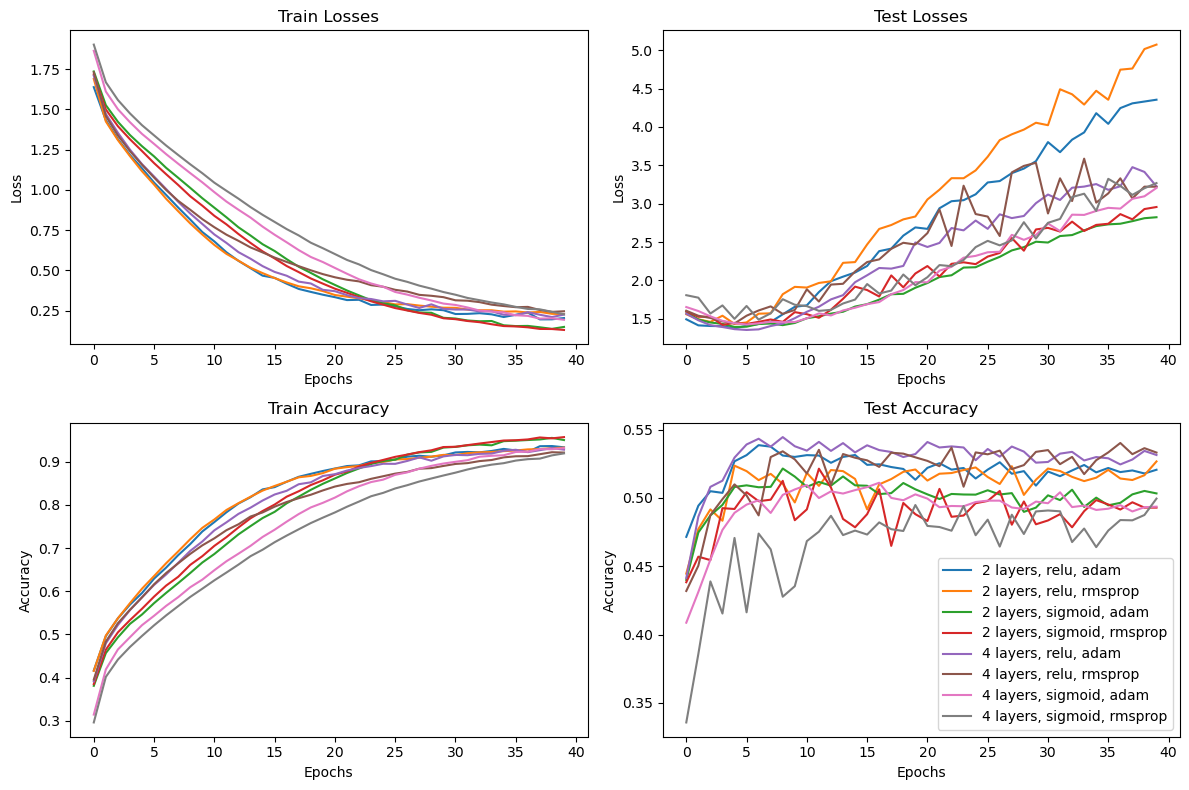

In [ ]:
# 实验不同配置
configs = [
    {'num_layers': 2, 'activation_func': 'relu', 'optimizer': 'adam'},
    {'num_layers': 2, 'activation_func': 'relu', 'optimizer': 'rmsprop'},
    {'num_layers': 2, 'activation_func': 'sigmoid', 'optimizer': 'adam'},
    {'num_layers': 2, 'activation_func': 'sigmoid', 'optimizer': 'rmsprop'},
    {'num_layers': 4, 'activation_func': 'relu', 'optimizer': 'adam'},
    {'num_layers': 4, 'activation_func': 'relu', 'optimizer': 'rmsprop'},
    {'num_layers': 4, 'activation_func': 'sigmoid', 'optimizer': 'adam'},
    {'num_layers': 4, 'activation_func': 'sigmoid', 'optimizer': 'rmsprop'},
]


# 训练并绘制曲线
plt.figure(figsize=(12, 8))

for config in configs:
    model = DefMLP(num_layers=config['num_layers'], activation_func=config['activation_func']).to(device)
    criterion = nn.CrossEntropyLoss()

    if config['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif config['optimizer'] == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    else:
        raise ValueError("Invalid optimizer")

    train_losses, train_accuracies, test_losses, test_accuracies = train(model, optimizer, criterion)

    # 训练集的损失和准确率
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Train Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')


    # 测试集的损失和准确率
    plt.subplot(2, 2, 2)
    plt.plot(test_losses, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Test Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # 训练集的准确率
    plt.subplot(2, 2, 3)
    plt.plot(train_accuracies, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # 测试集的准确率
    plt.subplot(2, 2, 4)
    plt.plot(test_accuracies, label=f'{config["num_layers"]} layers, {config["activation_func"]}, {config["optimizer"]}')
    plt.title(f'Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

plt.legend()
plt.tight_layout()
plt.show()

2. CNN模型训练

    - CNN1：采用交叉熵为损失函数，SGD作为优化器，学习率为0.01，动量为0.9

    - CNN2：采用交叉熵为损失函数，SGD作为优化器，学习率为0.001，动量为0.9

Epoch 1/20, Train Loss: 1.5551, Train Acc: 0.4400, Test Loss: 1.2091, Test Acc: 0.5678
Epoch 2/20, Train Loss: 1.1425, Train Acc: 0.5944, Test Loss: 1.0137, Test Acc: 0.6348
Epoch 3/20, Train Loss: 0.9849, Train Acc: 0.6536, Test Loss: 0.8920, Test Acc: 0.6905
Epoch 4/20, Train Loss: 0.8635, Train Acc: 0.6979, Test Loss: 0.8324, Test Acc: 0.7129
Epoch 5/20, Train Loss: 0.7835, Train Acc: 0.7249, Test Loss: 0.8035, Test Acc: 0.7258
Epoch 6/20, Train Loss: 0.7064, Train Acc: 0.7533, Test Loss: 0.7658, Test Acc: 0.7436
Epoch 7/20, Train Loss: 0.6460, Train Acc: 0.7737, Test Loss: 0.7120, Test Acc: 0.7596
Epoch 8/20, Train Loss: 0.5905, Train Acc: 0.7915, Test Loss: 0.7080, Test Acc: 0.7634
Epoch 9/20, Train Loss: 0.5389, Train Acc: 0.8128, Test Loss: 0.7312, Test Acc: 0.7563
Epoch 10/20, Train Loss: 0.4993, Train Acc: 0.8241, Test Loss: 0.6739, Test Acc: 0.7858
Epoch 11/20, Train Loss: 0.4552, Train Acc: 0.8420, Test Loss: 0.6748, Test Acc: 0.7731
Epoch 12/20, Train Loss: 0.4162, Train Ac

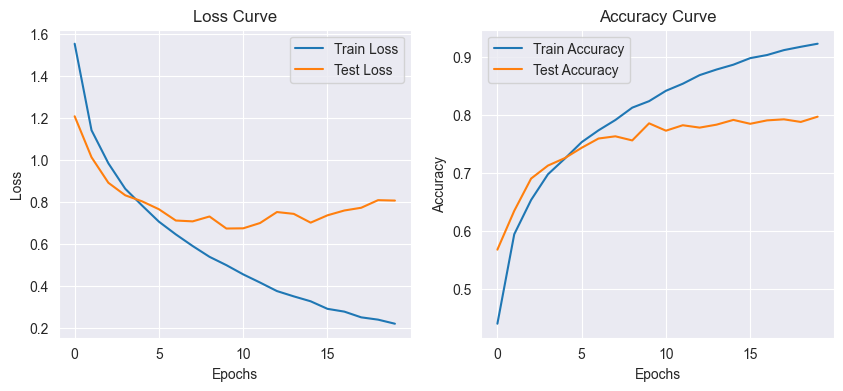

In [19]:
model = ConvNet().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20
train_losses_cnn1, train_accuracies_cnn1, test_losses_cnn1, test_accuracies_cnn1 = train(model, optimizer, criterion, num_epochs)

drawlines(train_losses_cnn1, train_accuracies_cnn1, test_losses_cnn1, test_accuracies_cnn1)

In [20]:
train_losses_all.append(train_losses_cnn1)
train_accuracies_all.append(train_accuracies_cnn1)
test_losses_all.append(test_losses_cnn1)
test_accuracies_all.append(test_accuracies_cnn1)

class_accuarcy_all.append(ClassTest(model))

Accuracy of   airplane : 76.79%
Accuracy of automobile : 94.0%
Accuracy of       bird : 78.48%
Accuracy of        cat : 49.32%
Accuracy of       deer : 72.73%
Accuracy of        dog : 74.58%
Accuracy of       frog : 92.86%
Accuracy of      horse : 87.5%
Accuracy of       ship : 87.93%
Accuracy of      truck : 82.05%


Epoch 1/20, Train Loss: 2.0260, Train Acc: 0.2783, Test Loss: 1.7360, Test Acc: 0.3857
Epoch 2/20, Train Loss: 1.6416, Train Acc: 0.4191, Test Loss: 1.4828, Test Acc: 0.4672
Epoch 3/20, Train Loss: 1.4750, Train Acc: 0.4745, Test Loss: 1.3842, Test Acc: 0.4976
Epoch 4/20, Train Loss: 1.3783, Train Acc: 0.5109, Test Loss: 1.2997, Test Acc: 0.5376
Epoch 5/20, Train Loss: 1.3107, Train Acc: 0.5339, Test Loss: 1.2451, Test Acc: 0.5529
Epoch 6/20, Train Loss: 1.2527, Train Acc: 0.5601, Test Loss: 1.1463, Test Acc: 0.5977
Epoch 7/20, Train Loss: 1.2016, Train Acc: 0.5771, Test Loss: 1.1468, Test Acc: 0.5907
Epoch 8/20, Train Loss: 1.1489, Train Acc: 0.5981, Test Loss: 1.0579, Test Acc: 0.6277
Epoch 9/20, Train Loss: 1.1037, Train Acc: 0.6150, Test Loss: 1.0250, Test Acc: 0.6416
Epoch 10/20, Train Loss: 1.0621, Train Acc: 0.6277, Test Loss: 1.0495, Test Acc: 0.6294
Epoch 11/20, Train Loss: 1.0243, Train Acc: 0.6429, Test Loss: 1.0315, Test Acc: 0.6297
Epoch 12/20, Train Loss: 0.9917, Train Ac

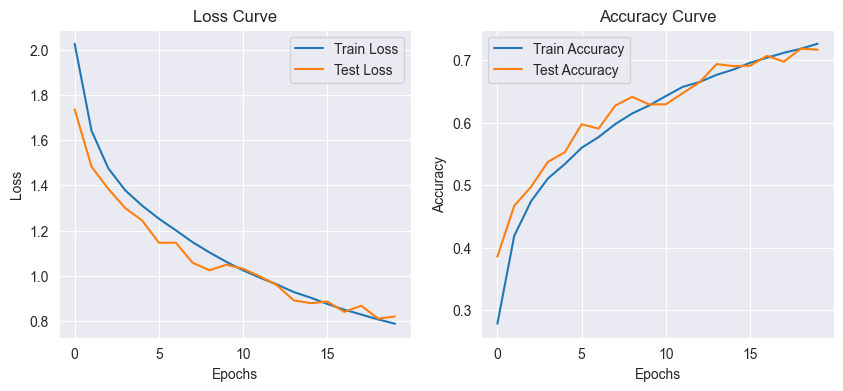

In [21]:
model = ConvNet().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 训练模型
num_epochs = 20
train_losses_cnn2, train_accuracies_cnn2, test_losses_cnn2, test_accuracies_cnn2 = train(model, optimizer, criterion, num_epochs)

drawlines(train_losses_cnn2, train_accuracies_cnn2, test_losses_cnn2, test_accuracies_cnn2)

In [22]:
train_losses_all.append(train_losses_cnn2)
train_accuracies_all.append(train_accuracies_cnn2)
test_losses_all.append(test_losses_cnn2)
test_accuracies_all.append(test_accuracies_cnn2)

class_accuarcy_all.append(ClassTest(model))

Accuracy of   airplane : 76.79%
Accuracy of automobile : 90.0%
Accuracy of       bird : 51.9%
Accuracy of        cat : 43.84%
Accuracy of       deer : 56.36%
Accuracy of        dog : 54.24%
Accuracy of       frog : 80.36%
Accuracy of      horse : 76.56%
Accuracy of       ship : 79.31%
Accuracy of      truck : 87.18%


Epoch 1/20, Train Loss: 1.6792, Train Acc: 0.3904, Test Loss: 1.2861, Test Acc: 0.5307
Epoch 2/20, Train Loss: 1.2091, Train Acc: 0.5703, Test Loss: 1.0398, Test Acc: 0.6374
Epoch 3/20, Train Loss: 0.9908, Train Acc: 0.6523, Test Loss: 0.8685, Test Acc: 0.6956
Epoch 4/20, Train Loss: 0.8497, Train Acc: 0.7018, Test Loss: 0.7695, Test Acc: 0.7357
Epoch 5/20, Train Loss: 0.7562, Train Acc: 0.7361, Test Loss: 0.7078, Test Acc: 0.7554
Epoch 6/20, Train Loss: 0.6845, Train Acc: 0.7621, Test Loss: 0.6798, Test Acc: 0.7686
Epoch 7/20, Train Loss: 0.6201, Train Acc: 0.7829, Test Loss: 0.6960, Test Acc: 0.7682
Epoch 8/20, Train Loss: 0.5736, Train Acc: 0.8004, Test Loss: 0.6166, Test Acc: 0.7883
Epoch 9/20, Train Loss: 0.5223, Train Acc: 0.8175, Test Loss: 0.6432, Test Acc: 0.7873
Epoch 10/20, Train Loss: 0.4870, Train Acc: 0.8311, Test Loss: 0.5890, Test Acc: 0.8045
Epoch 11/20, Train Loss: 0.4414, Train Acc: 0.8460, Test Loss: 0.6121, Test Acc: 0.8034
Epoch 12/20, Train Loss: 0.4061, Train Ac

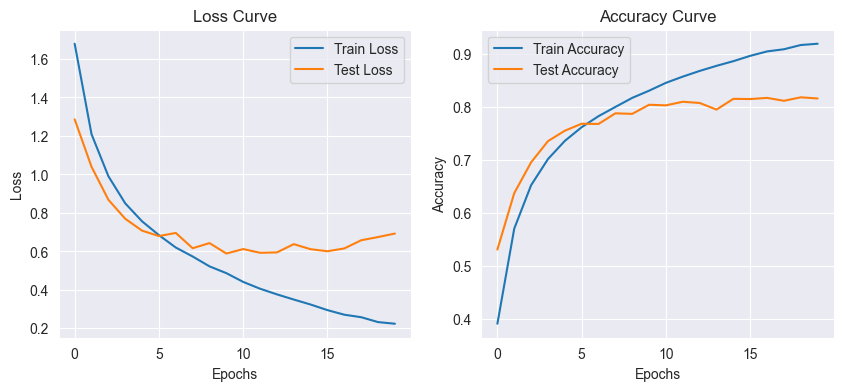

In [23]:
model = ConvNet_3layers().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20
train_losses_cnn3, train_accuracies_cnn3, test_losses_cnn3, test_accuracies_cnn3 = train(model, optimizer, criterion, num_epochs)

drawlines(train_losses_cnn3, train_accuracies_cnn3, test_losses_cnn3, test_accuracies_cnn3)

In [24]:
train_losses_all.append(train_losses_cnn3)
train_accuracies_all.append(train_accuracies_cnn3)
test_losses_all.append(test_losses_cnn3)
test_accuracies_all.append(test_accuracies_cnn3)

class_accuarcy_all.append(ClassTest(model))

Accuracy of   airplane : 94.64%
Accuracy of automobile : 88.0%
Accuracy of       bird : 82.28%
Accuracy of        cat : 52.05%
Accuracy of       deer : 76.36%
Accuracy of        dog : 67.8%
Accuracy of       frog : 85.71%
Accuracy of      horse : 92.19%
Accuracy of       ship : 93.1%
Accuracy of      truck : 84.62%


Epoch 1/20, Train Loss: 1.7726, Train Acc: 0.3501, Test Loss: 1.3796, Test Acc: 0.5034
Epoch 2/20, Train Loss: 1.2815, Train Acc: 0.5403, Test Loss: 1.0572, Test Acc: 0.6272
Epoch 3/20, Train Loss: 1.0551, Train Acc: 0.6276, Test Loss: 0.9845, Test Acc: 0.6618
Epoch 4/20, Train Loss: 0.9139, Train Acc: 0.6802, Test Loss: 0.8718, Test Acc: 0.7024
Epoch 5/20, Train Loss: 0.8156, Train Acc: 0.7154, Test Loss: 0.7704, Test Acc: 0.7311
Epoch 6/20, Train Loss: 0.7437, Train Acc: 0.7413, Test Loss: 0.7185, Test Acc: 0.7504
Epoch 7/20, Train Loss: 0.6846, Train Acc: 0.7602, Test Loss: 0.6933, Test Acc: 0.7603
Epoch 8/20, Train Loss: 0.6394, Train Acc: 0.7769, Test Loss: 0.6880, Test Acc: 0.7692
Epoch 9/20, Train Loss: 0.5948, Train Acc: 0.7917, Test Loss: 0.7465, Test Acc: 0.7493
Epoch 10/20, Train Loss: 0.5533, Train Acc: 0.8071, Test Loss: 0.7064, Test Acc: 0.7705
Epoch 11/20, Train Loss: 0.5240, Train Acc: 0.8157, Test Loss: 0.6568, Test Acc: 0.7820
Epoch 12/20, Train Loss: 0.4902, Train Ac

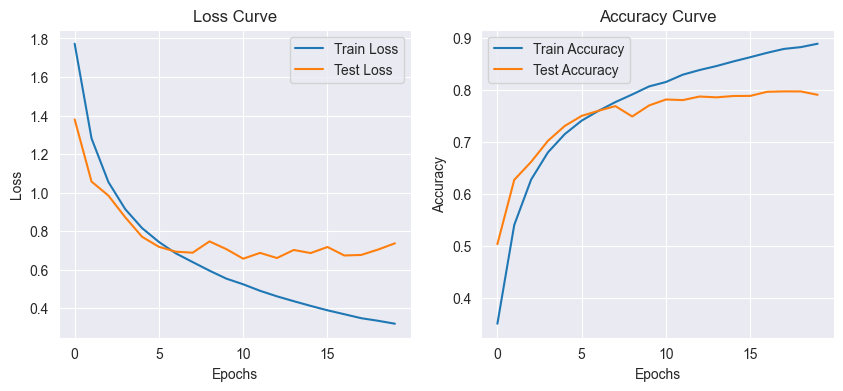

In [25]:
model = ConvNet_4().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20
train_losses_cnn4, train_accuracies_cnn4, test_losses_cnn4, test_accuracies_cnn4 = train(model, optimizer, criterion, num_epochs)

drawlines(train_losses_cnn4, train_accuracies_cnn4, test_losses_cnn4, test_accuracies_cnn4)

In [26]:
train_losses_all.append(train_losses_cnn4)
train_accuracies_all.append(train_accuracies_cnn4)
test_losses_all.append(test_losses_cnn4)
test_accuracies_all.append(test_accuracies_cnn4)

class_accuarcy_all.append(ClassTest(model))

Accuracy of   airplane : 83.93%
Accuracy of automobile : 94.0%
Accuracy of       bird : 62.03%
Accuracy of        cat : 57.53%
Accuracy of       deer : 70.91%
Accuracy of        dog : 67.8%
Accuracy of       frog : 87.5%
Accuracy of      horse : 90.62%
Accuracy of       ship : 87.93%
Accuracy of      truck : 87.18%


3. 采用批归一化的卷积网络模型训练

Epoch 1/20, Train Loss: 1.2519, Train Acc: 0.5552, Test Loss: 1.0241, Test Acc: 0.6386
Epoch 2/20, Train Loss: 0.9536, Train Acc: 0.6630, Test Loss: 0.9108, Test Acc: 0.6809
Epoch 3/20, Train Loss: 0.8260, Train Acc: 0.7097, Test Loss: 0.7729, Test Acc: 0.7341
Epoch 4/20, Train Loss: 0.7398, Train Acc: 0.7429, Test Loss: 0.7408, Test Acc: 0.7479
Epoch 5/20, Train Loss: 0.6760, Train Acc: 0.7629, Test Loss: 0.6748, Test Acc: 0.7661
Epoch 6/20, Train Loss: 0.6166, Train Acc: 0.7834, Test Loss: 0.6643, Test Acc: 0.7711
Epoch 7/20, Train Loss: 0.5674, Train Acc: 0.8024, Test Loss: 0.6699, Test Acc: 0.7754
Epoch 8/20, Train Loss: 0.5209, Train Acc: 0.8171, Test Loss: 0.6387, Test Acc: 0.7877
Epoch 9/20, Train Loss: 0.4845, Train Acc: 0.8311, Test Loss: 0.6345, Test Acc: 0.7888
Epoch 10/20, Train Loss: 0.4538, Train Acc: 0.8407, Test Loss: 0.6098, Test Acc: 0.7954
Epoch 11/20, Train Loss: 0.4206, Train Acc: 0.8547, Test Loss: 0.6415, Test Acc: 0.7932
Epoch 12/20, Train Loss: 0.3966, Train Ac

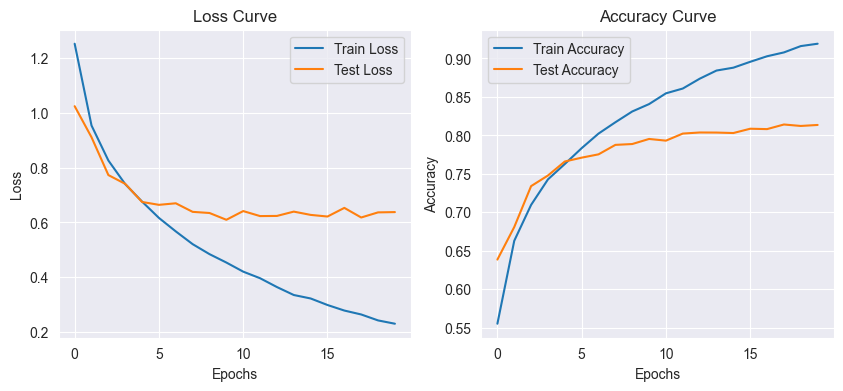

In [27]:
# 批归一化

# 选择模型
model = ConvNetBN().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20
train_losses_CnnBN, train_accuracies_CnnBN, test_losses_CnnBN, test_accuracies_CnnBN = train(model, optimizer, criterion, num_epochs)

# 绘制曲线
drawlines(train_losses_CnnBN, train_accuracies_CnnBN, test_losses_CnnBN, test_accuracies_CnnBN)

In [28]:
train_losses_all.append(train_losses_CnnBN)
train_accuracies_all.append(train_accuracies_CnnBN)
test_losses_all.append(test_losses_CnnBN)
test_accuracies_all.append(test_accuracies_CnnBN)

class_accuarcy_all.append(ClassTest(model))

Accuracy of   airplane : 91.07%
Accuracy of automobile : 98.0%
Accuracy of       bird : 75.95%
Accuracy of        cat : 52.05%
Accuracy of       deer : 80.0%
Accuracy of        dog : 72.88%
Accuracy of       frog : 91.07%
Accuracy of      horse : 89.06%
Accuracy of       ship : 89.66%
Accuracy of      truck : 84.62%


4. 采用早停法的ConvNetBN模型训练

Epoch 1/20, Train Loss: 1.2438, Train Acc: 0.5566, Test Loss: 0.9396, Test Acc: 0.6693
Epoch 2/20, Train Loss: 0.9447, Train Acc: 0.6642, Test Loss: 0.8616, Test Acc: 0.7050
Epoch 3/20, Train Loss: 0.8176, Train Acc: 0.7118, Test Loss: 0.7641, Test Acc: 0.7267
Epoch 4/20, Train Loss: 0.7354, Train Acc: 0.7432, Test Loss: 0.7968, Test Acc: 0.7332
Epoch 5/20, Train Loss: 0.6676, Train Acc: 0.7679, Test Loss: 0.7208, Test Acc: 0.7588
Epoch 6/20, Train Loss: 0.6109, Train Acc: 0.7862, Test Loss: 0.6457, Test Acc: 0.7807
Epoch 7/20, Train Loss: 0.5686, Train Acc: 0.7994, Test Loss: 0.6656, Test Acc: 0.7778
Epoch 8/20, Train Loss: 0.5215, Train Acc: 0.8194, Test Loss: 0.6468, Test Acc: 0.7922
Epoch 9/20, Train Loss: 0.4795, Train Acc: 0.8343, Test Loss: 0.6460, Test Acc: 0.7895
Validation loss has not decreased for 3 consecutive epochs. Early stopping...


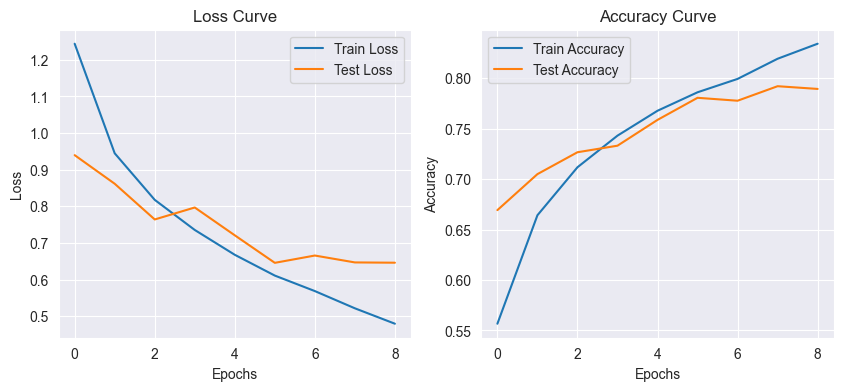

In [30]:
# 早停法

# 选择模型
model = ConvNetBN().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20

# 调用训练函数
train_losses_CnnBN_Estop, train_accuracies_CnnBN_Estop, test_losses_CnnBN_Estop, test_accuracies_CnnBN_Estop = train_with_early_stopping(model, optimizer, criterion, num_epochs)

# 绘制曲线
drawlines(train_losses_CnnBN_Estop, train_accuracies_CnnBN_Estop, test_losses_CnnBN_Estop, test_accuracies_CnnBN_Estop)

In [31]:
train_losses_all.append(train_losses_CnnBN_Estop)
train_accuracies_all.append(train_accuracies_CnnBN_Estop)
test_losses_all.append(test_losses_CnnBN_Estop)
test_accuracies_all.append(test_accuracies_CnnBN_Estop)

class_accuarcy_all.append(ClassTest(model))

Accuracy of   airplane : 91.07%
Accuracy of automobile : 92.0%
Accuracy of       bird : 64.56%
Accuracy of        cat : 49.32%
Accuracy of       deer : 69.09%
Accuracy of        dog : 74.58%
Accuracy of       frog : 91.07%
Accuracy of      horse : 85.94%
Accuracy of       ship : 86.21%
Accuracy of      truck : 85.9%


5. 采用早停法+Adam优化器的ConvNetBN模型训练

Epoch 1/20, Train Loss: 1.3244, Train Acc: 0.5300, Test Loss: 1.0863, Test Acc: 0.6188
Epoch 2/20, Train Loss: 0.9694, Train Acc: 0.6603, Test Loss: 0.8162, Test Acc: 0.7148
Epoch 3/20, Train Loss: 0.8391, Train Acc: 0.7085, Test Loss: 0.8088, Test Acc: 0.7156
Epoch 4/20, Train Loss: 0.7521, Train Acc: 0.7365, Test Loss: 0.7343, Test Acc: 0.7550
Epoch 5/20, Train Loss: 0.6845, Train Acc: 0.7611, Test Loss: 0.7183, Test Acc: 0.7605
Epoch 6/20, Train Loss: 0.6314, Train Acc: 0.7831, Test Loss: 0.7096, Test Acc: 0.7675
Epoch 7/20, Train Loss: 0.5909, Train Acc: 0.7945, Test Loss: 0.6750, Test Acc: 0.7769
Epoch 8/20, Train Loss: 0.5395, Train Acc: 0.8130, Test Loss: 0.6790, Test Acc: 0.7799
Epoch 9/20, Train Loss: 0.5082, Train Acc: 0.8234, Test Loss: 0.6525, Test Acc: 0.7894
Epoch 10/20, Train Loss: 0.4721, Train Acc: 0.8349, Test Loss: 0.6839, Test Acc: 0.7860
Epoch 11/20, Train Loss: 0.4412, Train Acc: 0.8447, Test Loss: 0.6976, Test Acc: 0.7915
Epoch 12/20, Train Loss: 0.4138, Train Ac

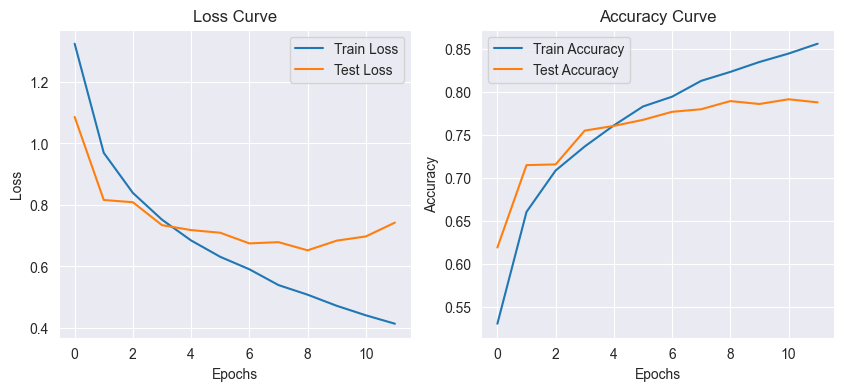

In [32]:
# 早停法+Adam优化器

# 选择模型
model = ConvNetBN().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练模型
num_epochs = 20

# 调用训练函数
train_losses_CnnBN_Estop_Adam, train_accuracies_CnnBN_Estop_Adam, test_losses_CnnBN_Estop_Adam, test_accuracies_CnnBN_Estop_Adam = train_with_early_stopping(model, optimizer, criterion, num_epochs)

# 绘制曲线
drawlines(train_losses_CnnBN_Estop_Adam, train_accuracies_CnnBN_Estop_Adam, test_losses_CnnBN_Estop_Adam, test_accuracies_CnnBN_Estop_Adam)

In [33]:
train_losses_all.append(train_losses_CnnBN_Estop_Adam)
train_accuracies_all.append(train_accuracies_CnnBN_Estop_Adam)
test_losses_all.append(test_losses_CnnBN_Estop_Adam)
test_accuracies_all.append(test_accuracies_CnnBN_Estop_Adam)

class_accuarcy_all.append(ClassTest(model))

Accuracy of   airplane : 85.71%
Accuracy of automobile : 94.0%
Accuracy of       bird : 75.95%
Accuracy of        cat : 36.99%
Accuracy of       deer : 74.55%
Accuracy of        dog : 86.44%
Accuracy of       frog : 76.79%
Accuracy of      horse : 82.81%
Accuracy of       ship : 93.1%
Accuracy of      truck : 83.33%


6. ResNet模型训练

d:\software\anaconda3\envs\jupyter\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\software\anaconda3\envs\jupyter\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\26822/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:08<00:00, 5.42MB/s]


Epoch 1/20, Train Loss: 1.1170, Train Acc: 0.6225, Test Loss: 0.7814, Test Acc: 0.7379
Epoch 2/20, Train Loss: 0.7924, Train Acc: 0.7322, Test Loss: 0.7026, Test Acc: 0.7628
Epoch 3/20, Train Loss: 0.7042, Train Acc: 0.7595, Test Loss: 0.6356, Test Acc: 0.7872
Epoch 4/20, Train Loss: 0.6103, Train Acc: 0.7909, Test Loss: 0.5797, Test Acc: 0.8040
Epoch 5/20, Train Loss: 0.5823, Train Acc: 0.8008, Test Loss: 0.5756, Test Acc: 0.8100
Epoch 6/20, Train Loss: 0.5218, Train Acc: 0.8211, Test Loss: 0.5376, Test Acc: 0.8190
Epoch 7/20, Train Loss: 0.4796, Train Acc: 0.8350, Test Loss: 0.5664, Test Acc: 0.8152
Epoch 8/20, Train Loss: 0.4482, Train Acc: 0.8444, Test Loss: 0.5505, Test Acc: 0.8208
Epoch 9/20, Train Loss: 0.4126, Train Acc: 0.8560, Test Loss: 0.5621, Test Acc: 0.8174
Epoch 10/20, Train Loss: 0.3797, Train Acc: 0.8662, Test Loss: 0.5167, Test Acc: 0.8330
Epoch 11/20, Train Loss: 0.3639, Train Acc: 0.8725, Test Loss: 0.5035, Test Acc: 0.8396
Epoch 12/20, Train Loss: 0.3394, Train Ac

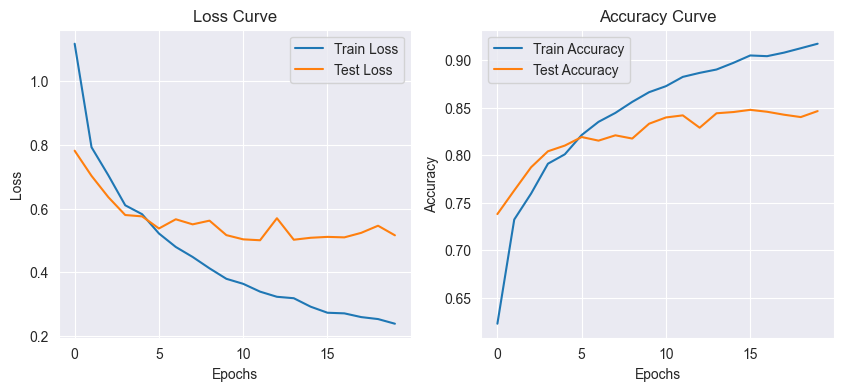

In [34]:
# 选择模型
model = torchvision.models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
num_epochs = 20

# 调用训练函数
train_losses, train_accuracies, test_losses, test_accuracies = train(model, optimizer, criterion, num_epochs)

# 绘制曲线
drawlines(train_losses, train_accuracies, test_losses, test_accuracies)

In [35]:
train_losses_all.append(train_losses)
train_accuracies_all.append(train_accuracies)
test_losses_all.append(test_losses)
test_accuracies_all.append(test_accuracies)

class_accuarcy_all.append(ClassTest(model))

Accuracy of   airplane : 89.29%
Accuracy of automobile : 98.0%
Accuracy of       bird : 83.54%
Accuracy of        cat : 61.64%
Accuracy of       deer : 81.82%
Accuracy of        dog : 66.1%
Accuracy of       frog : 91.07%
Accuracy of      horse : 92.19%
Accuracy of       ship : 98.28%
Accuracy of      truck : 88.46%


In [36]:
# 加载预训练的ResNet18模型
resnet18_pretrained = torchvision.models.resnet18(pretrained=True)

# 修改最后的全连接层以适应CIFAR-10的类别数（10类）
num_features = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_features, 10)

# 添加Batch Normalization层
model = nn.Sequential(
    resnet18_pretrained.conv1,
    resnet18_pretrained.bn1,
    resnet18_pretrained.relu,
    resnet18_pretrained.layer1,
    resnet18_pretrained.layer2,
    resnet18_pretrained.layer3,
    resnet18_pretrained.layer4,
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),  # 将特征张量展平
    nn.BatchNorm1d(num_features),  # Batch Normalization层
    nn.Linear(num_features, 10),  # 新的全连接层
)


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer_2 = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 调用训练函数
train_losses_1, train_accuracies_1, test_losses_1, test_accuracies_1 = train(model, optimizer_1, criterion, num_epochs=10)
train_losses_2, train_accuracies_2, test_losses_2, test_accuracies_2 = train(model, optimizer_2, criterion, num_epochs=10)

# 绘制曲线
drawlines(train_losses_1+train_losses_2, train_accuracies_1+train_accuracies_2, test_losses_1+test_losses_2, test_accuracies_1+test_accuracies_2)

Epoch 1/10, Train Loss: 0.8753, Train Acc: 0.7002, Test Loss: 0.6010, Test Acc: 0.7945
Epoch 2/10, Train Loss: 0.5327, Train Acc: 0.8164, Test Loss: 0.5368, Test Acc: 0.8218


In [ ]:
train_losses_all.append(train_losses_1+train_losses_2)
train_accuracies_all.append(train_accuracies_1+train_accuracies_2)
test_losses_all.append(test_losses_1+test_losses_2)
test_accuracies_all.append(test_accuracies_1+test_accuracies_2)

class_accuarcy_all.append(ClassTest(model))

Epoch 1/40, Train Loss: 0.9271, Train Acc: 0.6852, Test Loss: 0.6342, Test Acc: 0.7862
Epoch 2/40, Train Loss: 0.6261, Train Acc: 0.7873, Test Loss: 0.5130, Test Acc: 0.8208
Epoch 3/40, Train Loss: 0.5168, Train Acc: 0.8232, Test Loss: 0.4566, Test Acc: 0.8426
Epoch 4/40, Train Loss: 0.4548, Train Acc: 0.8451, Test Loss: 0.4441, Test Acc: 0.8480
Epoch 5/40, Train Loss: 0.4044, Train Acc: 0.8618, Test Loss: 0.4310, Test Acc: 0.8570
Epoch 6/40, Train Loss: 0.3661, Train Acc: 0.8753, Test Loss: 0.4325, Test Acc: 0.8522
Epoch 7/40, Train Loss: 0.3322, Train Acc: 0.8862, Test Loss: 0.4172, Test Acc: 0.8605
Epoch 8/40, Train Loss: 0.3001, Train Acc: 0.8961, Test Loss: 0.4656, Test Acc: 0.8541
Epoch 9/40, Train Loss: 0.2726, Train Acc: 0.9062, Test Loss: 0.4079, Test Acc: 0.8690
Epoch 10/40, Train Loss: 0.2485, Train Acc: 0.9127, Test Loss: 0.3852, Test Acc: 0.8718
Epoch 11/40, Train Loss: 0.2246, Train Acc: 0.9218, Test Loss: 0.3973, Test Acc: 0.8745
Epoch 12/40, Train Loss: 0.2108, Train Ac

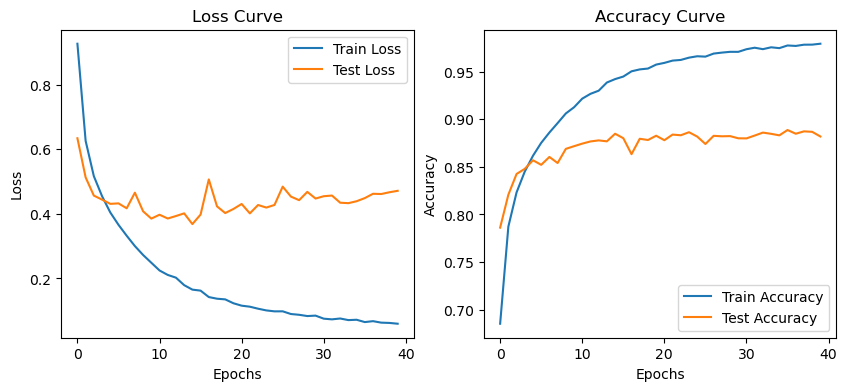

In [ ]:
# 加载预训练的ResNet18模型
resnet18_pretrained = torchvision.models.resnet18(pretrained=True)

# 修改最后的全连接层以适应CIFAR-10的类别数（10类）
num_features = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_features, 10)

# 添加Batch Normalization层
model = nn.Sequential(
    resnet18_pretrained.conv1,
    resnet18_pretrained.bn1,
    resnet18_pretrained.relu,
    resnet18_pretrained.layer1,
    resnet18_pretrained.layer2,
    resnet18_pretrained.layer3,
    resnet18_pretrained.layer4,
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),  # 将特征张量展平
    nn.BatchNorm1d(num_features),  # Batch Normalization层
    nn.Linear(num_features, 10),  # 新的全连接层
)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 训练模型
num_epochs = 20

# 调用训练函数
train_losses, train_accuracies, test_losses, test_accuracies = train(model, optimizer, criterion, num_epochs)

# 绘制曲线
drawlines(train_losses, train_accuracies, test_losses, test_accuracies)

In [ ]:
train_losses_all.append(train_losses)
train_accuracies_all.append(train_accuracies)
test_losses_all.append(test_losses)
test_accuracies_all.append(test_accuracies)

class_accuarcy_all.append(ClassTest(model))

### 2.4 模型对比

1. 对比各个模型的能力

    - MLP模型：SGD优化器
    - CNN模型：2层，SGD优化器，lr=0.01
    - CNN模型：2层，SGD优化器，lr=0.001
    - CNN模型：3层，SGD优化器，lr=0.01
    - CNN模型：3层，SGD优化器，lr=0.01，卷积核减半
    - CNN+BN模型：SGD优化器，lr=0.01
    - CNN+BN模型：SGD优化器，lr=0.01，早停法
    - CNN+BN模型：Adam优化器，早停法
    - ResNet模型：SGD优化器
    - ResNet+BN模型：SGD优化器
    - ResNet+BN模型：Adam优化器

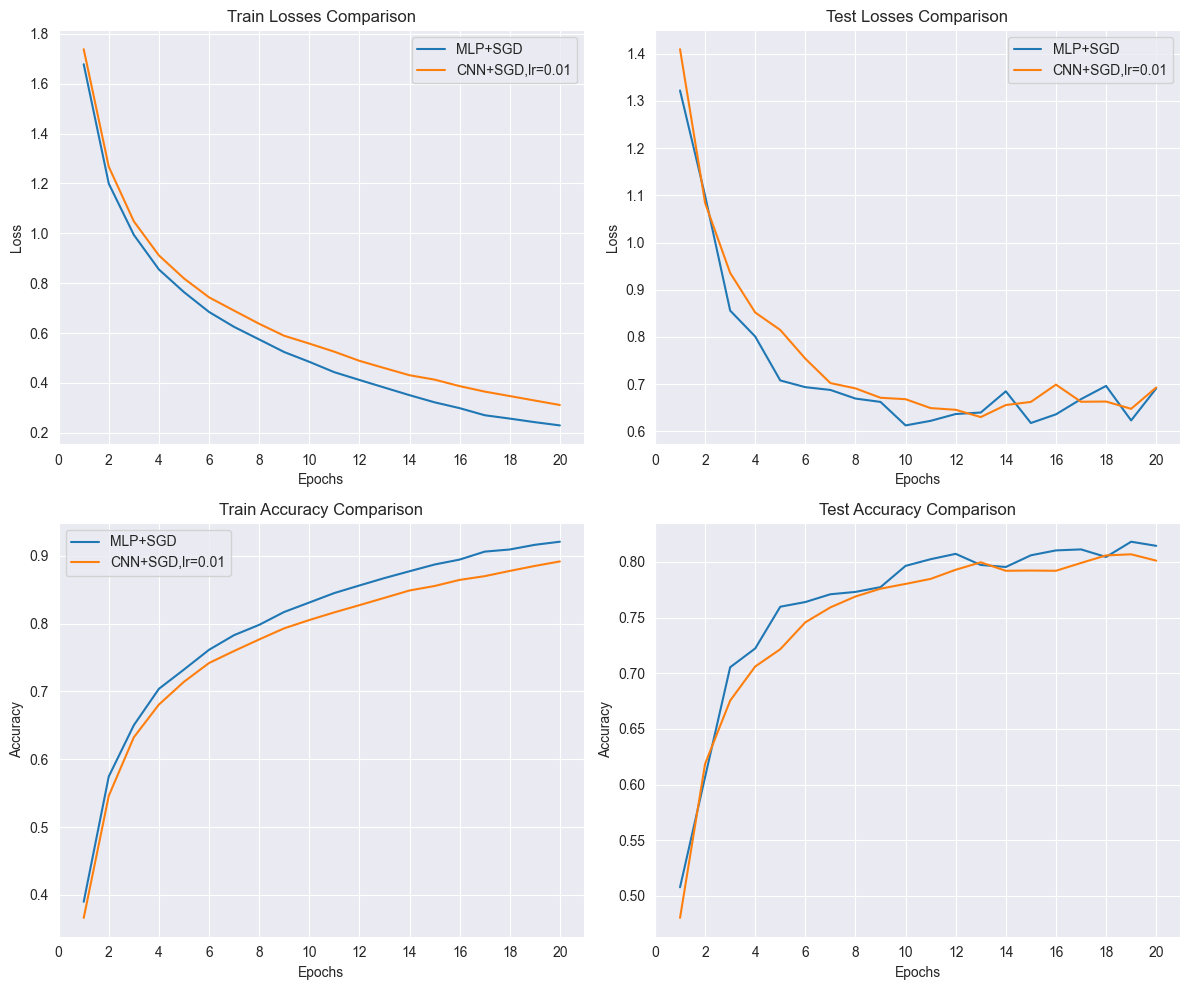

In [ ]:
epochs = list(range(1,21))
labels=['MLP+SGD','CNN+SGD,lr=0.01','CNN+SGD,lr=0.001','CNN+SGD,3层','CNN+SGD,3层','CNN+SGD,3层，卷积核减半',
        'CNN_BN+SGD','CNN_BN+SGD,早停法','CNN_BN+Adam,早停法','ResNet+SGD','ResNet_BN+SGD']

# 绘制 Train Loss 和 Test Loss 对比图
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
for i, train_loss in enumerate(train_losses_all):
    plt.plot(epochs, train_loss, label=labels[i])
plt.xticks(range(0, 21, 2), range(0, 21, 2))
plt.title('Train Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
for i, test_loss in enumerate(test_losses_all):
    plt.plot(epochs, test_loss, label=labels[i])
plt.xticks(range(0, 21, 2), range(0, 21, 2))
plt.title('Test Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制 Train Accuracy 和 Test Accuracy 对比图
plt.subplot(2, 2, 3)
for i, train_accuracy in enumerate(train_accuracies_all):
    plt.plot(epochs, train_accuracy, label=labels[i])
plt.xticks(range(0, 21, 2), range(0, 21, 2))
plt.title('Train Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
for i, test_accuracy in enumerate(test_accuracies_all):
    plt.plot(epochs, test_accuracy, label=labels[i])
plt.xticks(range(0, 21, 2), range(0, 21, 2))
plt.title('Test Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

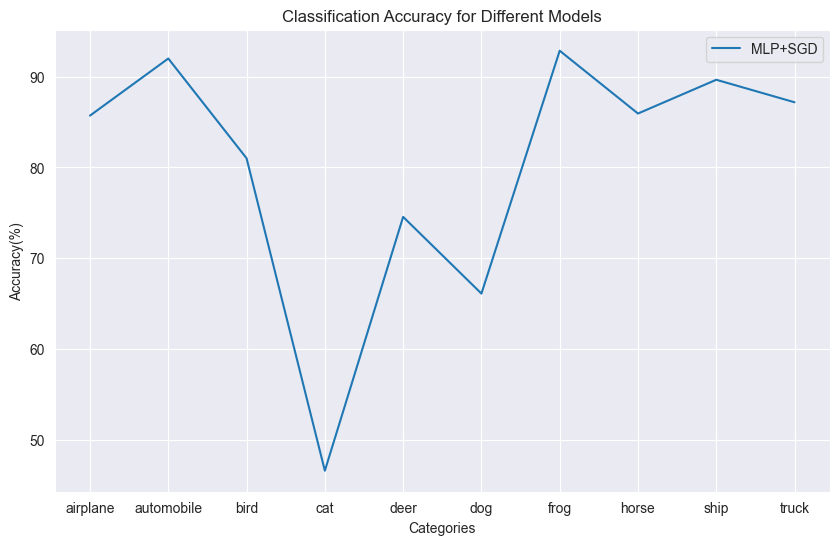

In [ ]:
# 类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 绘制折线图
plt.figure(figsize=(10, 6))

for i in range(len(class_accuarcy_all)):
    plt.plot(class_names, class_accuarcy_all[i], label=labels[i])

plt.xlabel('Categories')
plt.ylabel('Accuracy(%)')
plt.title('Classification Accuracy for Different Models')

plt.legend()
plt.show()